In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path

In [3]:
base_path = Path('.')

In [4]:
data_path = base_path / 'echovid_hackathon/data/'

## Data Loading

We import our data from csv files into pandas dataframes in order to edit them.

In [5]:
train_path, test_path = list(data_path.glob('*.csv'))

In [6]:
train = pd.read_csv(train_path).set_index('id')
test = pd.read_csv(test_path).set_index('id')
all =  pd.concat([train, test], sort=True).reset_index(drop=True)

In [7]:
train.head()

,Nom du centre,age,Sexe,Lieu de provenance du patient,Echographiste,Tabagisme actif,BPCO,Asthme,Autre antecedent respiratoire,Hypertension arterielle,Cardiopathie ischemique,Cardiopathie rythmique,Diabete de type 1,Diabete de type 2,Diabetes,Cancer hemopathie maligne,Demence,Statut immunodeprime,AINS au long cours (dans le cadre d'une pathologie suivie),AINS ponctuel recent (cadre des symptomatologies COVID-19 suspect avere),Tension arterielle systolique (mmHg),Tension arterielle diastolique (mmHg),Frequence cardiaque (puls. min),Frequence respiratoire (resp. min),Temperature (Celsius),Confusion,Saturation O2,Date de debut de la symptomatologie,Zone anterieure droite haut,Zone anterieure droite bas,Zone anterieure gauche haut,Zone anterieure gauche bas,Zone posterieure droite haut,Zone posterieure droite bas,Zone posterieure gauche haut,Zone posterieure gauche bas,Oxygenotherapie,Outcome J28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Paris-APHP - Cochin,91,Masculin,Domicile,Forme pour l'epidemie,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Non,164.0,64.0,80.0,35.0,37.7,Non,79.0,2020-04-18,Stade 2,Stade 2,Stade 1,Stade 2,Stade 2,Stade 2,Stade 2,Stade 2,NaN,Death
109,Paris-APHP - Hotel Dieu,45,Feminin,Domicile,Experience d'echographie,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,147.0,91.0,97.0,15.0,37.0,Non,99.0,2020-04-04,Stade 0,Stade 1,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Moderee,Back home
46,Melun - CH Marc Jacquet,76,Feminin,EHPAD,Experience d'echographie,Non,Non,Non,Non,Non,Oui,Non,Non,Oui,Oui,Non,Non,Non,Non,Non,119.0,72.0,89.0,27.0,37.2,Oui,97.0,NaN,Stade 0,Stade 1,Stade 1,Stade 0,Stade 1,Stade 2,Stade 1,Stade 2,Assistance respiratoire,Hospitalization
247,Paris-APHP - Hotel Dieu,55,Feminin,Hopital,Experience d'echographie,Oui,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,145.0,78.0,93.0,NaN,35.8,Non,100.0,NaN,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,NaN,Back home
195,Paris-APHP - Hotel Dieu,42,Feminin,Domicile,Experience d'echographie,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,126.0,80.0,89.0,16.0,37.0,Non,100.0,NaN,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,Stade 0,NaN,Back home


## Visualization and data cleaning

### Data Visualization

Class=Death, n=9 (3.435%)
Class=Back home, n=146 (55.725%)
Class=Hospitalization, n=96 (36.641%)
Class=Intensive care unit, n=11 (4.198%)


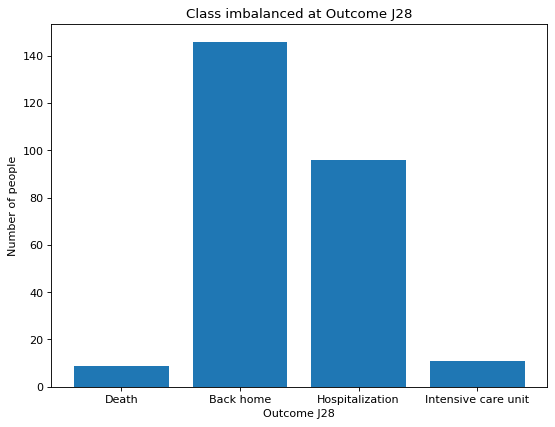

In [8]:
from collections import Counter
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

counter = Counter(train['Outcome J28'])
for k,v in counter.items():
    per = v / len(train['Outcome J28']) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.title('Class imbalanced at Outcome J28')
plt.xlabel('Outcome J28')
plt.ylabel('Number of people')
plt.show()

We can see that the imbalance between the 4 outcomes is significant. Therefore, since we aim at predicting death mainly we will have to give more importance to those criteria.

In [9]:
import missingno

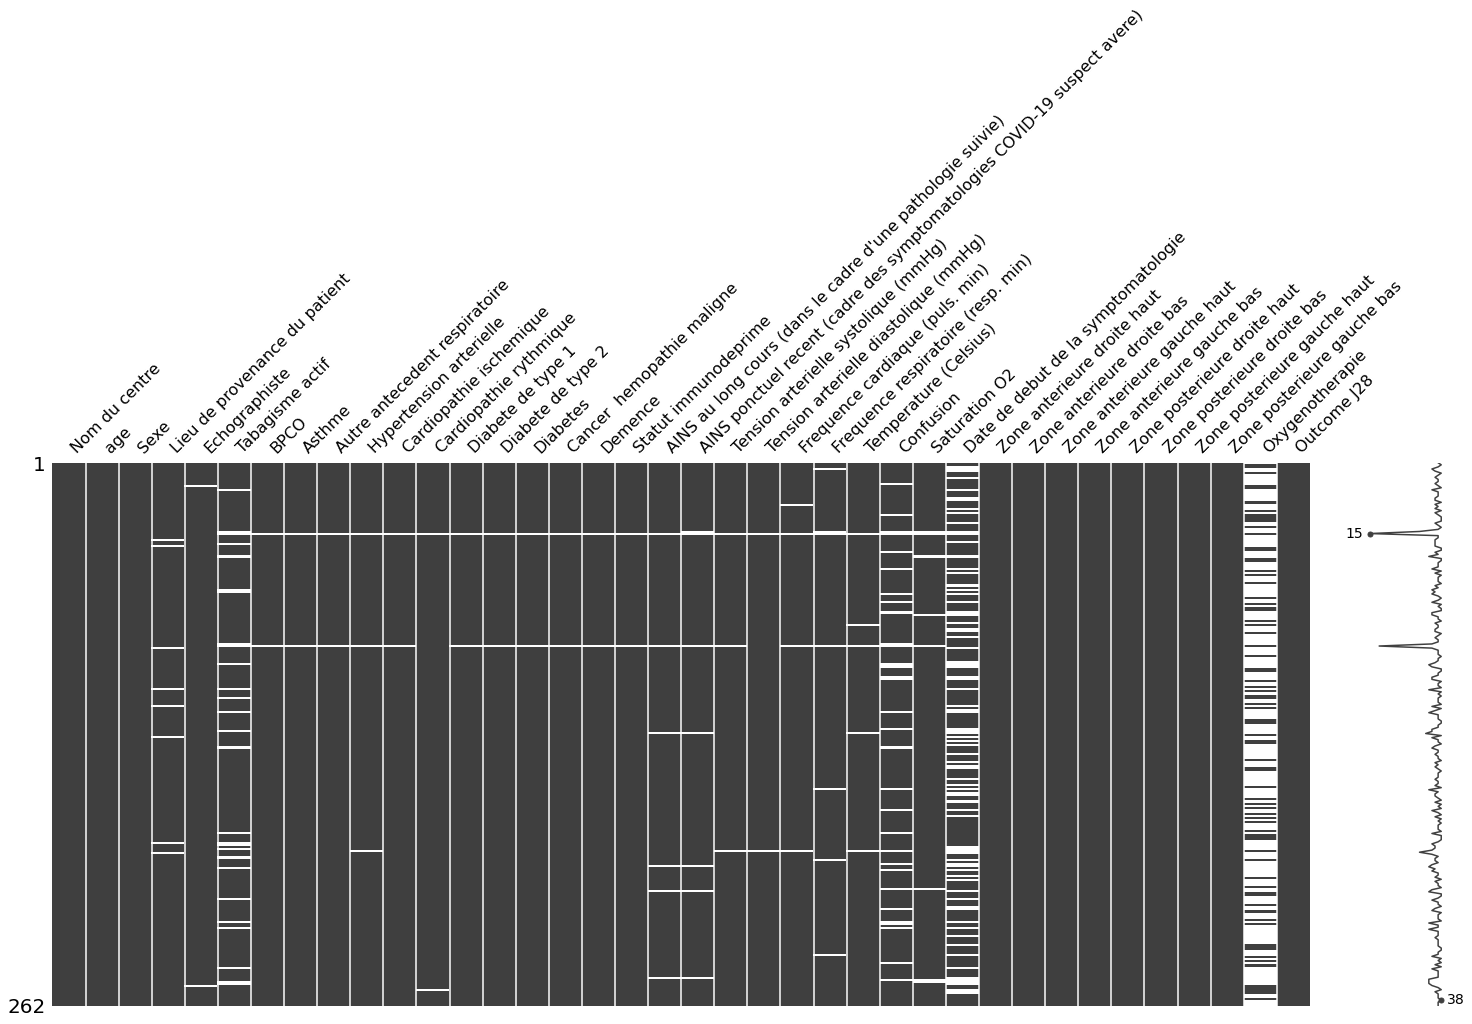

In [10]:
missingno.matrix(train)

This plot shows how many data are missing in our dataset. We can see that the 'Oxygenotherapie' column is quite empty. We will have to apply further treatment in order to not sabotage our predictions


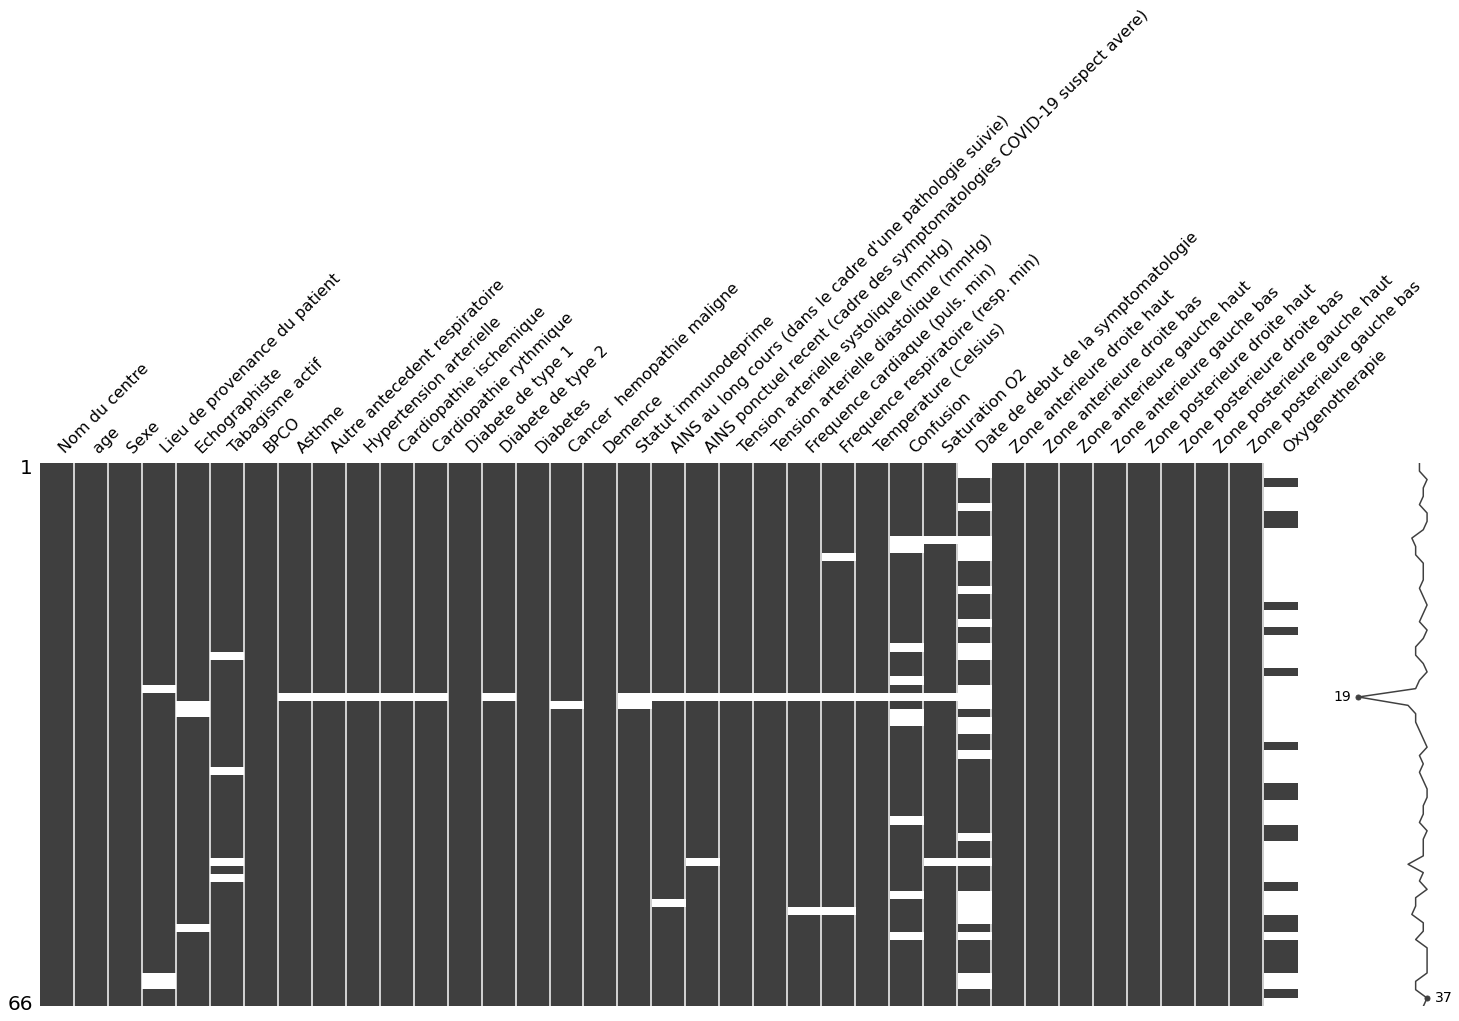

In [11]:
missingno.matrix(test)

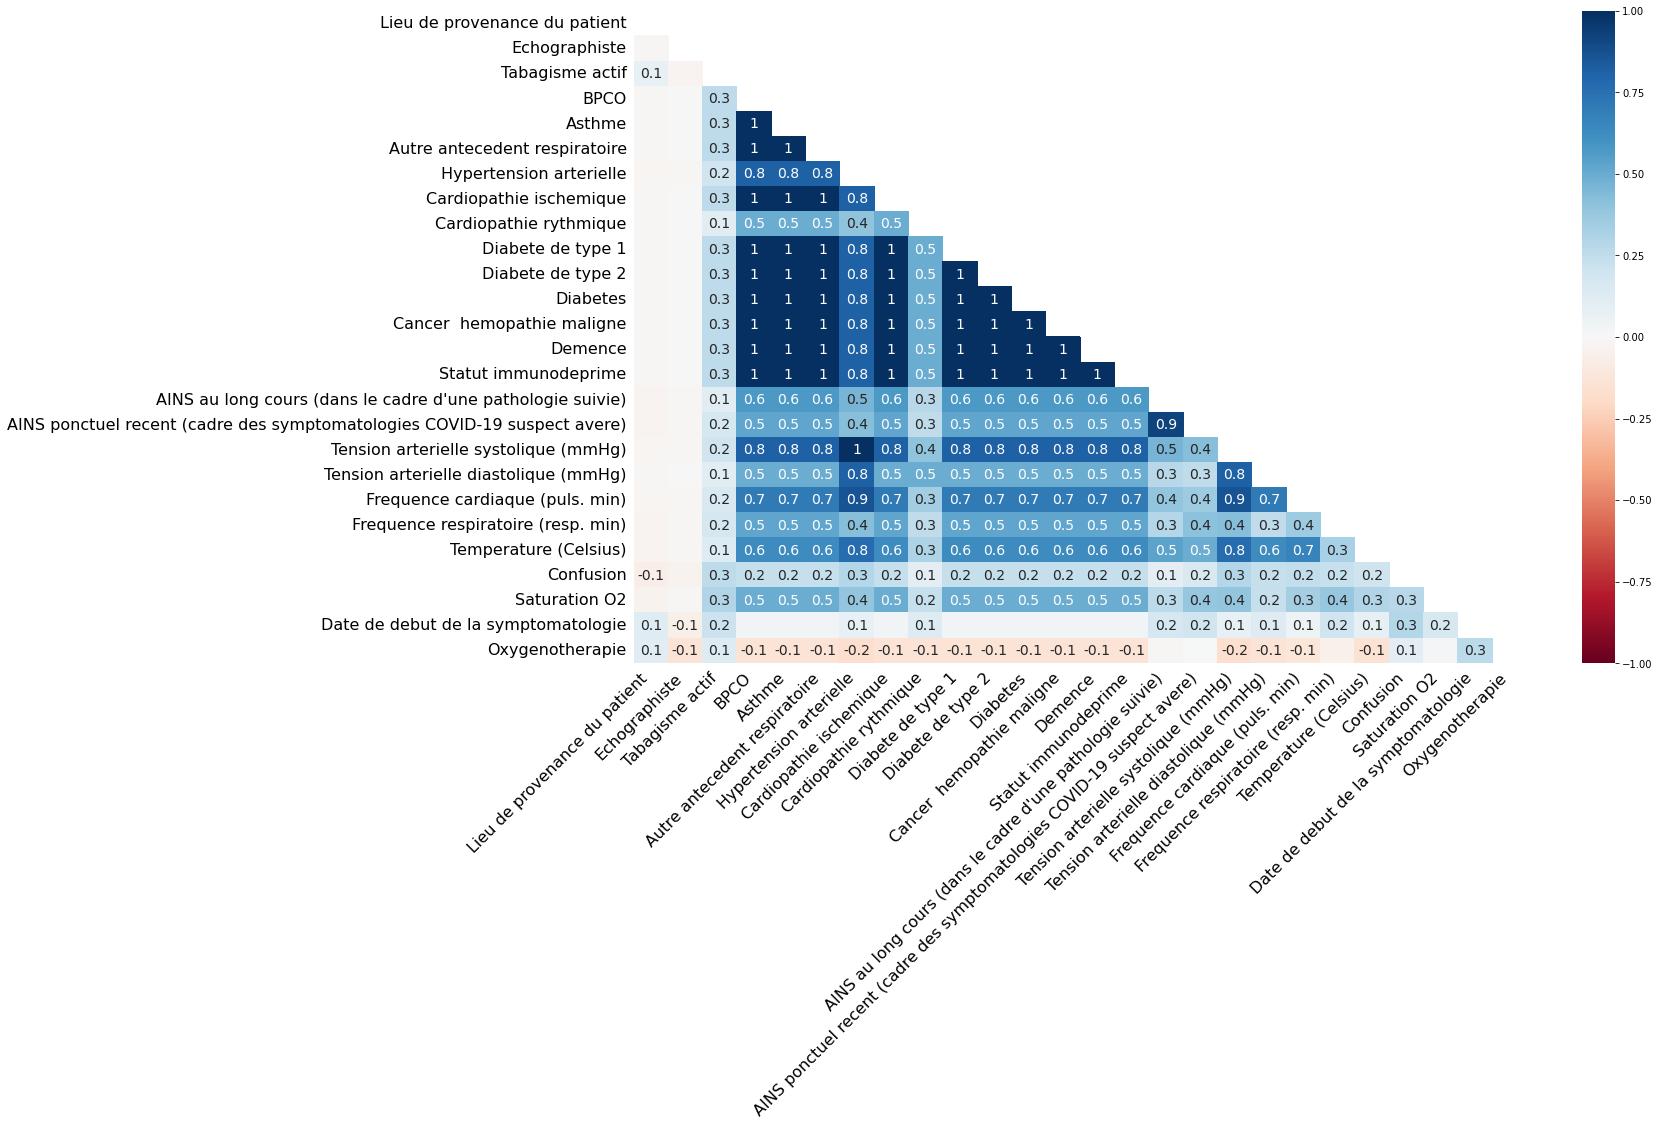

In [12]:
missingno.heatmap(train)

Values close to 1 stands for a strong correlation (if one variable appears the other definitely also does)​

Values close to 0 stands for "no effect"​

Values close to –1 stands for strong correlation (if one variable appears the other definitely not)​

### Data editing

All possible values:

In [13]:
for col in train:
    print(f"{col}: {train[col].unique()}\n")


Nom du centre: ['Paris-APHP - Cochin' 'Paris-APHP - Hotel Dieu' 'Melun - CH Marc Jacquet'
 'Strasbourg - CHRU de Strasbourg - Hautepierre'
 'Creteil - APHP - Henri Mondor' 'Montbrison - CH du Forez'
 'Paris-APHP - Lariboisiere']

age: [91 45 76 55 42 74 49 61 70 67 81 68 47 38 33 41 25 77 56 51 39 65 62 58
 64 24 40 71 84 48 31 35 52 54 46 79 36 30 50 59 69 63 60 43 73 90 83 93
 37 23 80 72 34 53 26 75 28 92 66 85 82 88 44 57]

Sexe: ['Masculin' 'Feminin']

Lieu de provenance du patient: ['Domicile' 'EHPAD' 'Hopital' 'Autre' nan]

Echographiste: ["Forme pour l'epidemie" "Experience d'echographie" 'Expert' nan]

Tabagisme actif: ['Non' 'Oui' nan]

BPCO: ['Non' 'Oui' nan]

Asthme: ['Non' 'Oui' nan]

Autre antecedent respiratoire: ['Non' 'Oui' nan]

Hypertension arterielle: ['Oui' 'Non' nan]

Cardiopathie ischemique: ['Non' 'Oui' nan]

Cardiopathie rythmique: ['Non' 'Oui' nan]

Diabete de type 1: ['Non' nan 'Oui']

Diabete de type 2: ['Non' 'Oui' nan]

Diabetes: ['Non' 'Oui' nan]

Cancer 

In [15]:
def clean_data(data):
    filter_col = [col for col in data if col.startswith('Zone ')]
    data[filter_col] = data[filter_col].apply(lambda x: x.str.strip('Stade '))
    data[filter_col] = data[filter_col].astype('int')
    data = data.replace({'Oui': True, 'Non': False})
    data = data.replace({'Masculin': 0, 'Feminin': 1})
    data = data.replace({'Domicile': 0, 'Autre': 1, 'EHPAD': 2, 'Hopital': 3})
    data = data.drop('Nom du centre', axis=1)
    data = data.replace({"Forme pour l'epidemie": 0, "Experience d'echographie": 1, 'Expert': 2})
    data = data.drop('Date de debut de la symptomatologie', axis=1)
    data = data.replace({'Air ambiant': 0, 'Moderee': 1, 'Assistance respiratoire': 2})
    data = data.replace({'Back home': 0, 'Hospitalization': 1, 'Intensive care unit': 2, 'Death': 3})
    return data

In [16]:
train, test = [clean_data(data) for data in [train, test]]

### Type convertions

In [17]:
# train.rename(columns={'Nom du centre' : 'center', 'Sexe':'gender', 'Lieu de provenance du patient' : 'origin_location', 'Echographiste' : 'sonographer', 'Tabagisme actif' : 'smoker', 'Asthme' : 'Asthma', 'Autre antecedent respiratoire' : 'Previous respiratory harm', })

convert_types = {
    'Tabagisme actif' : 'bool',
    'BPCO' : 'bool',
    'Asthme' : 'bool',
    'Autre antecedent respiratoire' : 'bool',
    'Hypertension arterielle' : 'bool',
    'Cardiopathie ischemique' : 'bool',
    'Cardiopathie rythmique' : 'bool',
    'Diabete de type 1' : 'bool',
    'Diabete de type 2' : 'bool',
    'Diabetes' : 'bool',
    'Cancer  hemopathie maligne' : 'bool',
    'Demence' : 'bool',
    'Statut immunodeprime' : 'bool',
    'AINS au long cours (dans le cadre d\'une pathologie suivie)' : 'bool',
    'AINS ponctuel recent (cadre des symptomatologies COVID-19 suspect avere)' : 'bool',
    'Confusion': 'bool',
    'Sexe': 'int',
}

train, test = [data.astype(convert_types) for data in [train, test]]
train['Outcome J28'] = train['Outcome J28'].astype('int')

In [18]:
train.dtypes

age                                                                           int64
Sexe                                                                          int64
Lieu de provenance du patient                                               float64
Echographiste                                                               float64
Tabagisme actif                                                                bool
BPCO                                                                           bool
Asthme                                                                         bool
Autre antecedent respiratoire                                                  bool
Hypertension arterielle                                                        bool
Cardiopathie ischemique                                                        bool
Cardiopathie rythmique                                                         bool
Diabete de type 1                                                           

### Correlations

In [19]:
df_all_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Outcome J28']

,Feature 1,Feature 2,Correlation Coefficient
0,Outcome J28,Outcome J28,1.000000
75,Outcome J28,Zone anterieure droite haut,0.644019
76,Outcome J28,Saturation O2,0.639290
79,Outcome J28,age,0.638239
82,Outcome J28,Zone anterieure gauche haut,0.630462
97,Outcome J28,Zone posterieure droite haut,0.599069
105,Outcome J28,Zone posterieure gauche haut,0.583821
119,Outcome J28,Zone posterieure gauche bas,0.535740
123,Outcome J28,Zone anterieure gauche bas,0.518821
129,Outcome J28,Zone anterieure droite bas,0.480062


### Data imputation

In [ ]:
!pip install fancyimpute

We use the MICE algorithm which stands for *Multivariate Imputation By Chained Equation*. The algorithm imputes missing data in a dataset through an iterative series of predictive models. In each iteration, each specified variable in the dataset is imputed using the other variables in the dataset.

In [21]:
from fancyimpute import IterativeImputer

In [22]:
mice_imputer = IterativeImputer()
mice = mice_imputer.fit_transform(train)
train = pd.DataFrame(data=mice, columns=train.columns, index=train.index)
mice = mice_imputer.fit_transform(test)
test = pd.DataFrame(data=mice, columns=test.columns, index=test.index)

In [23]:
train.head()

,age,Sexe,Lieu de provenance du patient,Echographiste,Tabagisme actif,BPCO,Asthme,Autre antecedent respiratoire,Hypertension arterielle,Cardiopathie ischemique,Cardiopathie rythmique,Diabete de type 1,Diabete de type 2,Diabetes,Cancer hemopathie maligne,Demence,Statut immunodeprime,AINS au long cours (dans le cadre d'une pathologie suivie),AINS ponctuel recent (cadre des symptomatologies COVID-19 suspect avere),Tension arterielle systolique (mmHg),Tension arterielle diastolique (mmHg),Frequence cardiaque (puls. min),Frequence respiratoire (resp. min),Temperature (Celsius),Confusion,Saturation O2,Zone anterieure droite haut,Zone anterieure droite bas,Zone anterieure gauche haut,Zone anterieure gauche bas,Zone posterieure droite haut,Zone posterieure droite bas,Zone posterieure gauche haut,Zone posterieure gauche bas,Oxygenotherapie,Outcome J28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,164.0,64.0,80.0,35.000000,37.7,0.0,79.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.006351,3.0
109,45.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147.0,91.0,97.0,15.000000,37.0,0.0,99.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
46,76.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,119.0,72.0,89.0,27.000000,37.2,1.0,97.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,2.000000,1.0
247,55.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,78.0,93.0,20.330176,35.8,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983541,0.0
195,42.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,80.0,89.0,16.000000,37.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968244,0.0


## Utils

In [24]:
def make_predictions(model, input):
    y_pred = model.predict(input)
    outcome_map = {'Back home': 0, 'Hospitalization': 1, 'Intensive care unit': 2, 'Death': 3}
    outcome_values = list(outcome_map.keys())
    y_pred = y_pred.astype(int)
    return [outcome_values[pred] for pred in y_pred]


In [25]:
from sklearn.metrics import f1_score, accuracy_score

def compute_f1_score(model, input, target):
    pred = model.predict(input)
    return f1_score(target, pred, average='micro')

In [26]:
def compute_accuracy_score(model, input, target):
    pred = model.predict(input)
    return accuracy_score(target, pred)

## Machine learning approach: XGBoost

### Preparation

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
def prepare_for_training(train):
    Y = train['Outcome J28'].values
    X = train.drop('Outcome J28', axis=1).values

    return train_test_split(X, Y, random_state=0)


In [29]:
x_train, x_val, y_train, y_val = prepare_for_training(train)

### Data resampling

In [77]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from math import floor

print('Distribution of y_train set befofore resampling: ', Counter(y_train))

nb_samples = len(y_train)

under = RandomUnderSampler(sampling_strategy={0: floor(0.35*nb_samples), 1: floor(0.35*nb_samples)}, random_state=11)
over = RandomOverSampler(sampling_strategy={2: floor(0.2*nb_samples), 3: floor(0.1*nb_samples)}, random_state=11)

x_train_under, y_train_under = under.fit_resample(x_train, y_train)
x_train_resampled, y_train_resampled = over.fit_resample(x_train_under, y_train_under)

print('Distribution of y_train set after resampling: ', Counter(y_train_resampled))

Distribution of y_train set befofore resampling:  Counter({0.0: 107, 1.0: 73, 2.0: 9, 3.0: 7})
Distribution of y_train set after resampling:  Counter({0.0: 68, 1.0: 68, 2.0: 39, 3.0: 19})


### Model

In [78]:
from xgboost import XGBClassifier, plot_importance, to_graphviz
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
import graphviz
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold

In [79]:
classifier = XGBClassifier(scale_pos_weight=99)
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=11, random_state=1)
classifier.fit(x_train_resampled, y_train_resampled)
    

scores = cross_val_score(classifier, x_train_resampled, y_train_resampled, cv=cv, n_jobs=-1)

print('Mean: %.5f' % mean(scores))

Mean: 0.91723


In [80]:
compute_f1_score(classifier, x_val, y_val)

0.8636363636363636

### Visualization

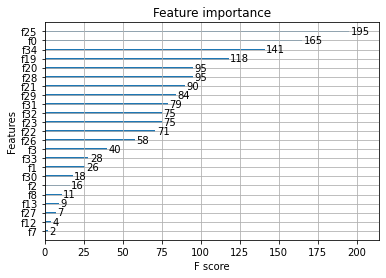

In [34]:
plot_importance(classifier)

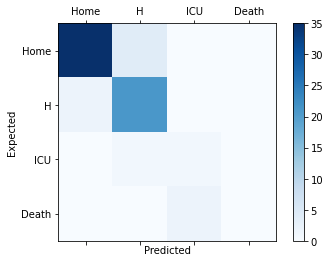

<Figure size 864x720 with 0 Axes>

In [35]:
from sklearn.metrics import confusion_matrix

pred = classifier.predict(x_val)
conf_mat = confusion_matrix(y_true=y_val, y_pred=pred)

labels = ['Home', 'H', 'ICU', 'Death']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')

figure(figsize=(12, 10))
plt.show()

### Predictions

In [81]:
xgboost_predictions = make_predictions(classifier, test.values)

## Deep learning approach: TabNet

### Preparation

In [37]:
from collections import namedtuple

Dataset = namedtuple('Dataset', [
    'x_train',
    'y_train',
    'x_val',
    'y_val',
    'x_test',
    'y_test',
])

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
def prepare_for_training(train):
    # label encoding
    Y = train['Outcome J28'].values
    X = train.drop('Outcome J28', axis=1).values

    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, random_state=0)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.3, random_state=0)
    return Dataset(x_train, y_train, x_val, y_val, x_test, y_test)

In [40]:
dataset = prepare_for_training(train)

### Data resampling

Class=3, n=9 (3.435%)
Class=0, n=146 (55.725%)
Class=1, n=96 (36.641%)
Class=2, n=11 (4.198%)


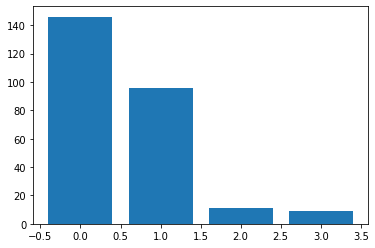

In [41]:
counter = Counter(train['Outcome J28'])
for k,v in counter.items():
	per = v / len(train['Outcome J28']) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
plt.bar(counter.keys(), counter.values())
plt.show()

In [42]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from math import floor

print('Distribution of y_train set befofore resampling: ', Counter(dataset.y_train))

nb_samples = len(dataset.y_train)

under = RandomUnderSampler(sampling_strategy={0: floor(0.3*nb_samples), 1: floor(0.3*nb_samples)})
over = RandomOverSampler(sampling_strategy={2: floor(0.2*nb_samples), 3: floor(0.2*nb_samples)})

x_train_under, y_train_under = under.fit_resample(dataset.x_train, dataset.y_train)
x_train_resampled, y_train_resampled = over.fit_resample(x_train_under, y_train_under)

print('Distribution of y_train set after resampling: ', Counter(y_train_resampled))

Distribution of y_train set befofore resampling:  Counter({0.0: 70, 1.0: 49, 2.0: 7, 3.0: 5})
Distribution of y_train set after resampling:  Counter({0.0: 39, 1.0: 39, 2.0: 26, 3.0: 26})


### Unsupervised pretraining

In [ ]:
!pip install pytorch-tabnet

In [53]:
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch

In [54]:
tabnet_unsupervised = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
)

Device used : cpu


In [ ]:
tabnet_unsupervised.fit(
    x_train_resampled,
    eval_set=[dataset.x_val],
    max_epochs=1000,
    batch_size=256, virtual_batch_size=128,
    patience=15,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
)

In [56]:
reconstructed_X, embedded_X = tabnet_unsupervised.predict(dataset.x_val)
assert(reconstructed_X.shape==embedded_X.shape)

In [57]:
unsupervised_explain_matrix, unsupervised_masks = tabnet_unsupervised.explain(dataset.x_val)

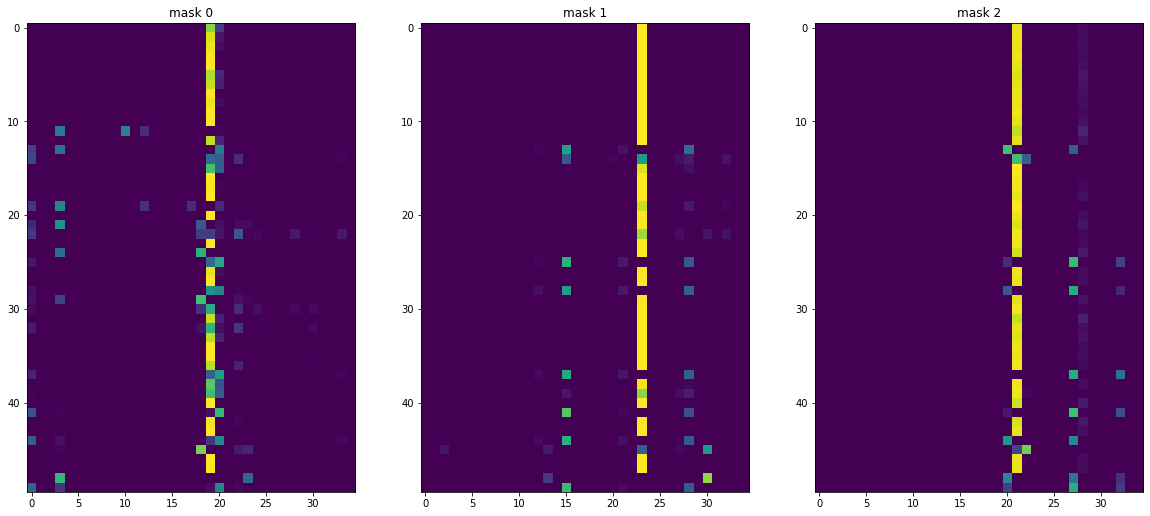

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

### Model

In [ ]:
!pip install pytorch_tabnet

In [60]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

In [61]:
tabnet = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

Device used : cpu


In [ ]:
tabnet.fit(
    x_train_resampled, y_train_resampled,
    eval_set=[(dataset.x_train, dataset.y_train), (dataset.x_val, dataset.y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=1000,
    patience=250,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=tabnet_unsupervised
)            

In [63]:
compute_accuracy_score(tabnet, dataset.x_test, dataset.y_test)

0.775

In [64]:
compute_f1_score(tabnet, dataset.x_test, dataset.y_test)

0.775

### Visualization

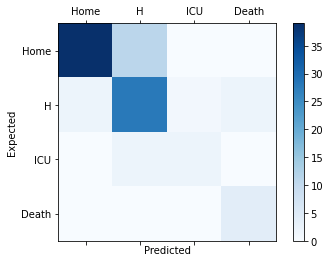

<Figure size 864x720 with 0 Axes>

In [65]:
from sklearn.metrics import confusion_matrix

pred = tabnet.predict(dataset.x_val)
conf_mat = confusion_matrix(y_true=dataset.y_val, y_pred=pred)

labels = ['Home', 'H', 'ICU', 'Death']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')

figure(figsize=(12, 10))
plt.show()

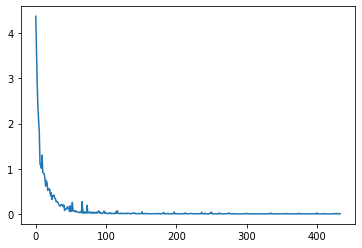

In [66]:
plt.plot(tabnet.history['loss'])

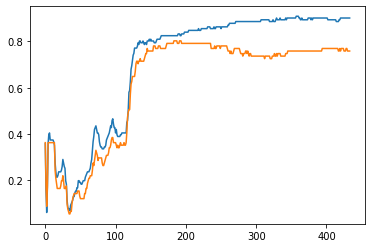

In [67]:
plt.plot(tabnet.history['train_accuracy'])
plt.plot(tabnet.history['valid_accuracy'])

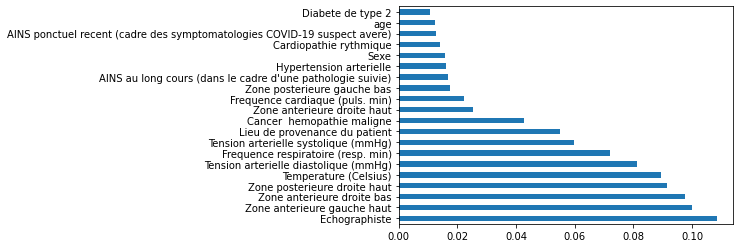

In [68]:
y_pred = tabnet.predict(dataset.x_test)
tabnet.feature_importances_
feat_importances = pd.Series(tabnet.feature_importances_, index=train.drop('Outcome J28', axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')

### Predictions

In [69]:
tabnet_predictions = make_predictions(tabnet, test.values)

## Export test predictions

In [82]:
xgboost_predictions_df = pd.DataFrame({'id': test.index.values, 'prediction': xgboost_predictions})
tabnet_predictions_df = pd.DataFrame({'id': test.index.values, 'prediction': tabnet_predictions})

In [83]:
tabnet_predictions_df

,id,prediction
0,237,Back home
1,236,Back home
2,253,Hospitalization
3,92,Death
4,53,Hospitalization
...,...,...
61,151,Hospitalization
62,39,Hospitalization
63,313,Hospitalization
64,134,Hospitalization


In [85]:
xgboost_predictions_df

,id,prediction
0,237,Back home
1,236,Back home
2,253,Hospitalization
3,92,Back home
4,53,Hospitalization
...,...,...
61,151,Hospitalization
62,39,Back home
63,313,Back home
64,134,Hospitalization


In [84]:
xgboost_predictions_df.to_csv('ginecho_xgboost.csv', index=False)
tabnet_predictions_df.to_csv('ginecho_tabnet.csv', index=False)